# Measuring Engagement and Satisfaction in Online Mental Health Platform Conversations

## Data preprocessing

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from math import log10, floor
import math
import nltk
import string
from nltk.tokenize import sent_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

pd.set_option('mode.chained_assignment',None)

In [208]:
# Display long column text
pd.options.display.max_colwidth = 500

df = pd.read_csv("mentalhealthsupport_dyadic_convs_clean_emotion.csv")
df = df.rename(columns={'conversation id': 'conversation_id', 'post title': 'post_title', 'dialog turn': 'dialog_turn', 'emotion prediction': 'emotion_prediction'})

In [209]:
### --- CLEANING OUT CONVERSATIONS WITH ONLY 1 OR 2 TURN(S) AND/OR WITH A SINGLE AUTHOR --- ###

# Group data by conversation id and calculate count of each conversation id
df_conv_len = df.groupby("conversation_id").count()
df_conv_len = df_conv_len.drop(columns=["subreddit", "post_title", "author", "text", "compound", "sentiment", "emotion_prediction"])
print("Number of conversations in subreddit: ", len(df_conv_len))

# Separate conversation id's with a single occurrence as monologues
df_mono = df_conv_len[df_conv_len["dialog_turn"] == 1]
#print("Number of conversations with a single turn in subreddit: ", len(df_mono))
df_mono_ids = df_mono.reset_index()
df_mono_ids = df_mono_ids["conversation_id"]

# Separate conversation id's with multiple occurrences as dialogues
df_dia = df_conv_len[df_conv_len["dialog_turn"] > 2]
print("Number of conversations longer than 2 turns in subreddit: ", len(df_dia))
df_dia = df_dia.reset_index()
df_dia = df_dia.drop(columns=['dialog_turn'])

# Join dialogue conversation id's with original data such that only dialogues remain in the dataset
df = df.join(df_dia.set_index('conversation_id'), on='conversation_id', how="right") 

# Separate conversations that have more than one author
df_conv_authors = df.groupby("conversation_id")["author"].unique().reset_index()
df_conv_authors["author"] = df_conv_authors["author"].apply(lambda x: x.size)
df_conv_authors = df_conv_authors[df_conv_authors["author"] > 1]
df_conv_authors = df_conv_authors.drop(columns=['author'])

# Join dialogue conversation id's with original data such that only conversations that have more than one author remain in the dataset
df = df.join(df_conv_authors.set_index('conversation_id'), on='conversation_id', how="right") 
print("Number of conversations longer than 2 turns with more than a single author in subreddit: ", len(df_conv_authors))

### ---------------------------------------------- ###

Number of conversations in subreddit:  3551
Number of conversations longer than 2 turns in subreddit:  487
Number of conversations longer than 2 turns with more than a single author in subreddit:  476


In [210]:
# Round numbers to a given number of significant figures (default = 2)
def round_sig(x, sig=2):
    if x != 0:
        return round(x, sig-int(floor(log10(abs(x))))-1)
    else:
        return

## Extracting conversation, speaker, and listener

In [211]:
def extract_responses(conversation_id):
    conversation = df[df["conversation_id"] == conversation_id]
    conversation.reset_index(drop=True, inplace=True)
    speaker = conversation.author.iloc[0]
    listener = conversation[conversation["author"] != speaker]["author"].unique().item() 
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses) 
    num_listener_responses = len(listener_responses)
    # TOIMPROVE: you can only keep conversation, speaker, and listener (because others are dynamic and can be calculated from these 3)
    return conversation, speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses

## Measuring the level of engagement

In [212]:
# Calculates token length for all speaker responses except for the first and adds it to a new column 'token_length', and returns their sum.
def calculate_speaker_token_length(conversation, speaker):
    # Create an empty dataframe column 'token_length'
    conversation.loc[:,'token_length'] = np.nan
    
    sum_token_length = 0
    
    for i in range(1, len(conversation)):
        if conversation['author'].iloc[i] == speaker:
            # Tokenize speaker response and filter punctuations
            tokens = nltk.word_tokenize(conversation["text"][i])
            tokens = list(filter(lambda tokens: tokens not in string.punctuation, tokens)) # TOIMPROVE: exclude quotation marks
            
            # Add token length to dataframe
            conversation.at[i,'token_length'] = len(tokens)
            
            # Calculate sum of all tokens by speaker
            sum_token_length += len(tokens)
        
    return conversation, sum_token_length

In [213]:
def merge_consecutive_speaker_responses(conversation, speaker, listener):
    i = 0
    
    while i < (len(conversation) - 1):
        if conversation['author'].iloc[i] == speaker and conversation['author'].iloc[i+1] == speaker:
            if (conversation['dialog_turn'].iloc[i] + 1) == conversation['dialog_turn'].iloc[i+1]:
                dropped_turn = conversation['dialog_turn'].iloc[i+1]
                former_text = conversation['text'][i]
                latter_text = conversation['text'][i+1]

                # Merge consecutive responses of the speaker
                merged_text = former_text + " " + latter_text 
                conversation['text'].replace({former_text: merged_text}, inplace=True)

                # Get names of indexes for which column dialog_turn has value of the dropped turn
                conversation_index_names = conversation[conversation['dialog_turn'] == dropped_turn].index

                # Delete these row indexes from dataframe
                conversation.drop(conversation_index_names, inplace=True)

                # Reset indexes
                conversation.reset_index(drop=True, inplace=True)
                
        i += 1
        
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses) 
    num_listener_responses = len(listener_responses)
                 
    return conversation, num_speaker_responses, num_listener_responses

In [214]:
# Checks if conversation is interleaved. 
# If all the even-numbered turns are by the speaker and if all the odd-numbered turns are by the listener, returns True. Otherwise, returns False.
def is_interleaved_conversation(speaker, listener, conversation):
    num_turns = len(conversation)
    
    for i in range(0, num_turns, 2):
        if conversation['author'].iloc[i] == speaker:
            continue
        else:
            return False
        
    for i in range(1, num_turns, 2):
        if conversation['author'].iloc[i] == listener:
            continue
        else:
            return False
        
    return True

In [215]:
def calculate_engagement_score(num_turns, interleaved, sum_token_length, diff):
    num_turns_weight = 1
    interleaved_weight = 1
    token_length_weight = 1
    diff_weight = 1
    
    if interleaved == True:
        interleaved_int = 1
    else:
        interleaved_int = 0
    
    return num_turns_weight*num_turns + interleaved_weight*interleaved + token_length_weight*sum_token_length + diff_weight*diff

In [216]:
def calculate_engagement(speaker, listener, conversation):
    conversation, num_speaker_responses, num_listener_responses = merge_consecutive_speaker_responses(conversation, speaker, listener)
    conversation, sum_token_length = calculate_speaker_token_length(conversation, speaker)
    diff = num_speaker_responses - num_listener_responses
    diff = abs(diff)
    interleaved = is_interleaved_conversation(speaker, listener, conversation)
    num_turns = len(conversation)
    engagement = ""
    threshold = 2
    
    engagement_score = calculate_engagement_score(num_turns, interleaved, sum_token_length, diff)
    
    # TODO: if engagement_score > 2:
        
    if num_turns == 2:
        engagement = "low engagement"
        
    elif num_turns == 3:
        if is_interleaved_conversation(speaker, listener, conversation) == True and sum_token_length > 15: # TOASK: What number to choose as token length? Is it logical to use it like this?
            engagement = "moderate engagement" 
        else:
            engagement = "low engagement"
            
    elif num_turns >= 4:
        if (is_interleaved_conversation(speaker, listener, conversation) == True or (diff <= 1)) and sum_token_length > 15: 
            engagement = "high engagement" 
        else:
            engagement = "low engagement"
    
    # TODO: Create a function that takes a weighted sum of these individual measures. Take a subset and calculate for each weight and inspect (which weight is most meaningful?) --> like a compound score
            
    return round_sig(diff), engagement

## Measuring the level of satisfaction

In [217]:
def plot_emotion_sentiment(speaker_responses):   
    sns.set_theme(style="white")
    g = sns.relplot(x="dialog_turn", y="compound", hue="sentiment", style="emotion_prediction", palette="Set1",data=speaker_responses, s=200)
    g.fig.suptitle('Sentimental and Emotional Shift in Speaker Responses with Conversation Progression', fontsize=16)
    g.fig.subplots_adjust(top=0.9);

In [218]:
# Return all emotions and the final emotion of the given responses
def get_emotion_prediction(speaker_responses):
    emotions = speaker_responses["emotion_prediction"]
    final_emotion = emotions.iloc[-1]
    
    return emotions, final_emotion

In [219]:
# Return all sentiments and the final sentiment of the given responses
def get_sentiment(speaker_responses):
    sentiments = speaker_responses["sentiment"]
    final_sentiment = sentiments.iloc[-1]
    
    return sentiments, final_sentiment

In [220]:
# Check if the last speaker emotion is grateful and its sentiment is positive. If yes, return true. Otherwise, return false.
def is_tagged_grateful_positive(speaker_responses):
    _, final_sentiment = get_sentiment(speaker_responses)
    _, final_emotion = get_emotion_prediction(speaker_responses)
    
    if final_sentiment == "positive" and final_emotion == "grateful":
        return True
    
    return False

In [221]:
def contains_grateful_tokens(conversation, speaker):
    index = 0
    
    # Takes the last speaker response
    for i in range(len(conversation)-1,0,-1):
        if conversation['author'].iloc[i] == speaker:
            index = i
            break
   
    tokens = nltk.word_tokenize(conversation["text"].iloc[index].lower())
    tokens = list(filter(lambda tokens: tokens not in string.punctuation, tokens)) # TOIMPROVE: exclude quotation marks
    
    # TODO: finish lexicon of gratitude words towards listener 
    gratitude_words = ['thank', 'means a lot to me', 'thanks', 'appreciate', 'your support', 'your help']
    
    if gratitude_words in tokens: 
        return True
        
    return False

In [222]:
# def is_offended(conversation):
    

In [223]:
# Creates a column with sentence-level sentiment compounds
def sent_lvl_sentiment(conversation):
    conversation['sentences'] = conversation['text'].apply(lambda x: sent_tokenize(x)) 
    conversation['sentence_compounds'] = conversation['sentences']
    
    for i in range(0,len(conversation)):
        num_sentences = len(sent_tokenize(conversation['text'].iloc[i]))
        # sentiment compound for each sentence
        scores = np.zeros(num_sentences) 
        for j in range(0,num_sentences):
            # i'th dialogue turn, j'th sentence
            scores[j] = sid.polarity_scores(sent_tokenize(conversation['text'][i])[j])['compound']

            conversation['sentence_compounds'][i] = scores
            
    return conversation

In [224]:
# Creates a column with the sentence compound with strongest magnitude within a dialogue turn
def strongest_sentiment(conversation):
    conversation['strongest_compound'] = conversation['sentence_compounds']
    conversation['strongest_compound'] = conversation['strongest_compound'].apply(lambda x: np.min(x) if np.max(abs(x)) == abs(np.min(x)) else np.max(x))
    
    return conversation

In [225]:
# TODO IN LATER WEEKS?
def emobert_predict_sentence_emotion(conversation):
    conversation['sent_emotion_prediction'] = conversation['sentences']
    
    for i in range(0,len(conversation)):
        num_sentences = len(sent_tokenize(conversation['text'].iloc[i]))
        # emotion for each sentence
        emotions = np.zeros(num_sentences) 
        for j in range(0,num_sentences):
            # i'th dialogue turn, j'th sentence
            emotions[j] = sent_tokenize(conversation['text'][i])[j].swifter.apply(emobert_predict_emotion)
            conversation['sent_emotion_prediction'][i] = emotions
            
    return conversation

In [226]:
def calculate_satisfaction_score(slope, sentiment_change, grateful_bonus, offended_penalty):
    slope_weight = 1
    sentiment_change_weight = 1
    grateful_bonus_weight = 1
    offended_penalty_weight = 1
    
    return slope_weight*slope + sentiment_change_weight*sentiment_change + grateful_bonus_weight*grateful_bonus + offended_penalty_weight*offended_penalty

In [227]:
#conversation, speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses = extract_responses(24)
#speaker_responses = conversation[conversation["author"] == speaker]
#conversation

In [228]:
#conversation = sent_lvl_sentiment(conversation)
#conversation = strongest_sentiment(conversation)
#conversation

In [229]:
def calculate_satisfaction(conversation, speaker):
    conversation = sent_lvl_sentiment(conversation)
    conversation = strongest_sentiment(conversation)
    speaker_responses = conversation[conversation["author"] == speaker]
    num_speaker_responses = len(speaker_responses)
    
    satisfaction = ""
    grateful_bonus = 0
    offended_penalty = 0
    threshold = 2
    
    # Change in sentiment from the first to the last turn
    sentiment_change = speaker_responses['strongest_compound'].iloc[-1] - speaker_responses['strongest_compound'].iloc[0]
    
    # Take the slope of the compounds of speaker responses
    f = np.polyfit(speaker_responses['dialog_turn'], speaker_responses['compound'], deg=1)
    slope = f[0]

    if is_tagged_grateful_positive(speaker_responses)==True or contains_grateful_tokens(speaker_responses, speaker)==True:
        grateful_bonus = 1
        
    # TODO: offended penalty 
              
    satisfaction_score = calculate_satisfaction_score(slope, sentiment_change, grateful_bonus, offended_penalty)
                                         
    if satisfaction_score > threshold:
        satisfaction = "highly satisfying"
    else:
        satisfaction = "less satisfying"
        
    return round_sig(slope), sentiment_change, grateful_bonus, offended_penalty, satisfaction_score, satisfaction

## Final classification

In [230]:
def classify_conversation(speaker_responses, num_speaker_responses, num_listener_responses, conversation, speaker, listener):
    return str(calculate_engagement(speaker, listener, conversation)[-1] + ", " + calculate_satisfaction(conversation, speaker)[-1])

## Testing the measures

In [231]:
def test_examples(conversation_id):
    conversation, speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses = extract_responses(conversation_id)
    plot_emotion_sentiment(speaker_responses)
    print("Conversation length: ", len(conversation))
    print("Speaker-listener turn difference: ", calculate_engagement(speaker, listener, conversation)[0], " --> ", calculate_engagement(speaker, listener, conversation)[1])
    print("Sentiment slope: ", calculate_satisfaction(conversation, speaker)[0], ", sentiment change: ", calculate_satisfaction(conversation, speaker)[1], ", grateful bonus: ", 
          calculate_satisfaction(conversation, speaker)[2], ", offended penalty: ", calculate_satisfaction(conversation, speaker)[3]), "SATISFACTION SCORE: ", 
    calculate_satisfaction(conversation, speaker)[4], "SATISFACTION : ", calculate_satisfaction(conversation, speaker)[5], 
    print("Classification summary: ", classify_conversation(speaker_responses, num_speaker_responses, num_listener_responses, conversation, speaker, listener))

In [232]:
conversation_id = 23
df[df["conversation_id"] == conversation_id]

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
52,23,MentalHealthSupport,I've been having a horrible recurring dream.,jacksongray213,1,"(Just an FYI I've posted this in other places but I'm new to Reddit and I'm not sure where this best fits) Hey there guys, for the past month or so I have a reoccurring dream that happens probably once every 2-3 nights. It's really starting to drive me crazy. Just a heads up, this dream is pretty inappropriate and has a lot of gross and graphic things happening so if you don't want to read something like that, please move on. Basically what happens is I start out in a dark room, then some ...",0.9970,positive,anticipating
53,23,MentalHealthSupport,I've been having a horrible recurring dream.,normalornotwhoa,2,"Hey there. That sounds really frightening. I'll share with you what I learned in therapy to help rid yourself of nightmares. Write down in a book or on your phone the story of what happens in the dream, but when bad things start to happen, imagine something positive happening instead. The more fantastical it is the better (not sure why that helps but it does). So write that you sprout wings and fly away, or shoot fire out of your mouth and kill your enemies and then ride an elephant to...",0.7072,positive,guilty
54,23,MentalHealthSupport,I've been having a horrible recurring dream.,jacksongray213,3,"Thank you for the response. I'm going to try that tonight. Hopefully it will work, I'll get back to you!",0.6696,positive,guilty


Conversation length:  3
Speaker-listener turn difference:  1  -->  moderate engagement
Sentiment slope:  -0.16 , sentiment change:  -0.3662 , grateful bonus:  0 , offended penalty:  0
Classification summary:  moderate engagement, less satisfying


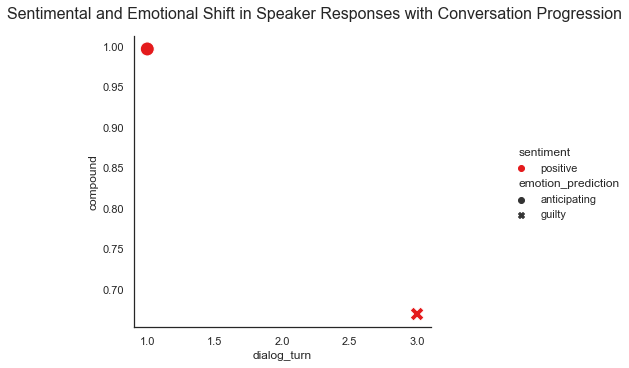

In [233]:
test_examples(conversation_id) 

## More examples

### High engagement, neutral satisfaction (but should be positive satisfaction)

In [234]:
df[df["conversation_id"] == 1732]

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
4125,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,1,"I’m kinda worried about posting this here because I don’t know if it is correct or not but I’m stuck in a very bad anxiety hole atm, I posted this in one of the legal advice subs and everyone said it’s more of a mental health problem, (also sorry I don’t know how to do paragraphs) ok so recently every single day and night I’ve been having panic attacks over something that happened 2-3 years ago, when I was 13 I was on pornhub and came across Ben 10 hentai and being thirty I was very stupid a...",-0.9960,negative,anticipating
4126,1732,MentalHealthSupport,"Hello, I need some advice/help",SophieSofar,2,No it's not illegal and you won't get in trouble for it. Especially as pornhub is legal. There's weirder things on there like scooby doo or American dad sketches. We all get curious. There's nothing to worry about x,0.8477,positive,faithful
4127,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,3,"Thank you so much, I’ve felt so bad for so long, I was at the point where I can’t handle it anymore, I know this whole thing sounds stupid but I have been having serious suicidal thoughts over it, after reading your comment I’m crying lol, I was so worried about posting this but I’m at the point where it was either a suicidal help line or this, I chose this because I wasn’t brave enough for the latter but seriously thank you I was so nervous, also please excuse my lack of ability to do parag...",-0.9430,negative,anxious
4128,1732,MentalHealthSupport,"Hello, I need some advice/help",SophieSofar,4,No problem. I was the same when I started exploring that side of the web. It's harmless x,0.5037,positive,sentimental
4129,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,5,So do you really think I’ll be ok?,0.0000,neutral,sentimental
4130,1732,MentalHealthSupport,"Hello, I need some advice/help",SophieSofar,6,Yeah for sure. Pornhub can't have anything illegal on there or they'll lose their licence,0.5753,positive,angry
4131,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,7,"I was just really worried because i read that even hentai which is underage is illegal, so as you could probably guess I had a panic attack, but it’s been 2-3 years so I don’t think I’ll be in trouble right? And I never downloaded it",-0.8688,negative,embarrassed
4132,1732,MentalHealthSupport,"Hello, I need some advice/help",SophieSofar,8,Kids sent each other weirder stuff when I was in school. If nothing has happened by now it won't happen x,-0.1280,negative,embarrassed
4133,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,9,"Thank you, your really nice which really helps my anxiety, I hope you have an amazing year, also would it be ok if I ever messaged you just in case I was worrying?",0.9189,positive,sentimental
4134,1732,MentalHealthSupport,"Hello, I need some advice/help",SophieSofar,10,No problem. Hopefully this advice will allow you to move forward with your life x,0.2263,positive,sentimental


Conversation length:  10
Speaker-listener turn difference:  None  -->  high engagement
Sentiment slope:  0.2 , sentiment change:  1.9149 , grateful bonus:  0 , offended penalty:  0
Classification summary:  high engagement, highly satisfying


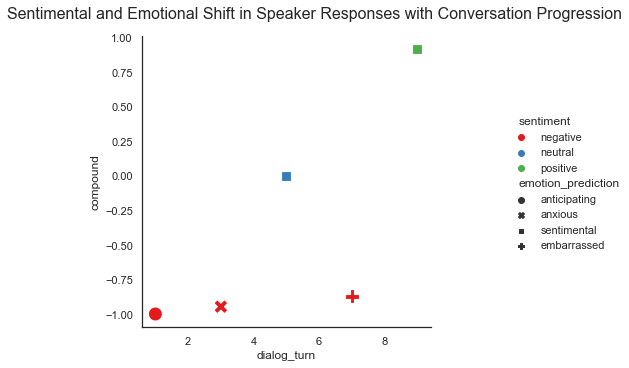

In [235]:
test_examples(1732) 

### High engagement, moderate satisfaction

In [236]:
df[df["conversation_id"] == 1003]

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
2418,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,1,"A bit of background information. I smoked weed twice in my life, first time in november of 2018 and second in april of 2019. both times i had extreme panic attacks that were amplified by my depersonalization disorder. I get really stressed out when I think about those episodes I had, and worry about death constantly. Recently, my girlfriend has admitted to me that she’s been smoking weed regularly for over a year. I don’t know why, but that bothered me and put me in a really depressed moo...",-0.9820,negative,grateful
2419,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,2,"Well, I'm going to take a stab at it and say that you have mixed feelings and anxiety because you've been raised to think of weed as a bad thing and it's been demonized. So there's already a stigma there for you when it comes to the drug. Then there's the other side of it, which is you tried it, you had a severe panic attack (which can happen depending on the type of weed. I've had one as well with some kinds, and not with others. And I've had depersonalization on weed too. Your frame of min...",-0.8813,negative,anxious
2420,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,3,"you hit the nail on the head with that egg analogy. except if i were you, i’d be under this false idea that eggs are killing everyone and turning them into shitty burnouts. i don’t know why.",-0.8402,negative,sentimental
2421,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,4,Awww. I’m sorry you feel that way. I’d look into why you’re having that reaction to it. 💗,0.6808,positive,sentimental
2422,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,5,i feel so alone in my life and it eats me up inside to hear that the one i love is having a normal reaction to it. i feel left out and angry at the same time and i just cut my wrists tonight to get my mind off of her. i’m a fucking wreck,-0.7192,negative,embarrassed
2423,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,6,Did you self-harm or attempt suicide? Are you okay?!,-0.6430,negative,sentimental
2424,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,7,self harm.,-0.5423,negative,surprised
2425,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,8,How are you doing today?,0.0000,neutral,grateful
2426,1003,MentalHealthSupport,Mood swings from random bits of information.,q-6u,9,"i’ve been mych, much better since i last logged into reddit. thanks for sticking around, and for your help. seriously.",0.7783,positive,grateful
2427,1003,MentalHealthSupport,Mood swings from random bits of information.,you_are_marvelous,10,So glad to hear that! And you’re very welcome. :),0.8795,positive,anticipating


In [ ]:
test_examples(1003) 

Conversation length:  10
Speaker-listener turn difference:  None  -->  high engagement
Sentiment slope: 

### High engagement, neutral satisfaction

In [ ]:
df[df["conversation_id"] == 854]

In [ ]:
test_examples(854) 

### Moderate engagement, neutral satisfaction

This is also an example with merged speaker turns. 

In [ ]:
df[df["conversation_id"] == 24]

In [ ]:
test_examples(24) 

### Low engagement, moderate satisfaction

In [ ]:
df[df["conversation_id"] == 35]

In [ ]:
test_examples(35) 

**Satisfaction:**
- make scoring numerical (like a compound score column)
    - put a weight to all the factors 
        - experiment and inspect which weights and threshold yield a good scoring
- Take off points if speaker got offended from listener's response 
- Find a lexicon of gratitude tokens

**Engagement:**
- make scoring numerical (like a compound score column)
    - put a weight to all the factors 
        - experiment and inspect which weights and threshold yield a good scoring

**Examples:**
- A few examples showing low/moderate/high engagement/satisfaction